In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer 
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from sklearn.metrics import mean_absolute_percentage_error
from datetime import timedelta

ModuleNotFoundError: No module named 'statsmodels'

In [3]:
data = pd.read_csv('../raw_data/df_energy_weather.csv')

In [4]:
data_origin = data.copy()

In [5]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

In [6]:
def replace_val(df,date1,date2): #on remplace les NaN dans l intervalle de date
    for col in df.columns:
        m_value = (data[col][date1] + data[col][date2])/2
        imputer = SimpleImputer(strategy='constant',fill_value=m_value) # Instantiate a SimpleImputer object with your strategy of choice
        imputer.fit(data[[col]]) # Call the "fit" method on the object
        data[col] = imputer.transform(data[[col]]) # Call the "transform" method on the object
        
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 2 #'spring'
    if date in seasons['summer']:
        return 3 #'summer'
    if date in seasons['autumn']:
        return 0 #'autumn'
    else:
        return 1 #'winter'
    
def duree_jour(day_year):
    return np.cos(-np.pi*day_year/180+2*np.pi)

In [7]:
data = data.set_index('Date').asfreq('D')

In [22]:
#pd.Series([pd.to_datetime('2015-01-01'),pd.to_datetime('2015-01-05')]).asfreq('D')
df = pd.DataFrame(['2015-01-01','2015-01-05'])
df = df.set_index(0).asfreq('D')
df

""
0
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05


In [7]:
data = data.rename(columns={"cos_day": "cos7_1", "sin_day": "sin7_1"})

In [8]:
data['day_of_year'] = data.index[:].dayofyear
data['duree_du_jour'] = data['day_of_year'].apply(duree_jour)

In [9]:
data.index[0]

Timestamp('2013-01-01 00:00:00', freq='D')

In [10]:
data['season'] = data.index
data['season'] = data['season'].apply(season_of_date)

In [11]:
data['sin365_1']=np.sin(2*np.pi*data['day_of_year']/365.25)
data['cos365_1']=np.cos(2*np.pi*data['day_of_year']/365.25)
data['sin365_2']=np.sin(4*np.pi*data['day_of_year']/365.25)
data['cos365_2']=np.cos(4*np.pi*data['day_of_year']/365.25)
data['sin365_3']=np.sin(8*np.pi*data['day_of_year']/365.25)
data['cos365_3']=np.cos(8*np.pi*data['day_of_year']/365.25)

In [12]:
replace_val(data,'2022-04-30','2022-05-06') #remplacement des NaN
data['Date'] = data.index

'''
ind_min = 700
ind_max = 735#len(data)# 200
plt.figure(figsize=(15,6))
plt.plot(data['Consommation (MW)'][ind_min:ind_max],color='blue',label = 'Consommation (MW)')
plt.plot(data['T2M'][ind_min:ind_max]*7000+150000,color='red',label = 'T2M')
plt.legend()
'''

"\nind_min = 700\nind_max = 735#len(data)# 200\nplt.figure(figsize=(15,6))\nplt.plot(data['Consommation (MW)'][ind_min:ind_max],color='blue',label = 'Consommation (MW)')\nplt.plot(data['T2M'][ind_min:ind_max]*7000+150000,color='red',label = 'T2M')\nplt.legend()\n"

In [13]:
scaler = StandardScaler()
data['T2M'] = scaler.fit_transform(data[['T2M']])
data['RH2M'] = scaler.fit_transform(data[['RH2M']])

In [14]:
data

,Unnamed: 0,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),...,day_of_year,duree_du_jour,season,sin365_1,cos365_1,sin365_2,cos365_2,sin365_3,cos365_3,Date
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,4464.0,252371.0,15175.0,0.0,372.0,405.0,61254.0,-4.0,1808.0,...,1,0.999848,1,0.017202,0.999852,0.034398,0.999408,0.068755,0.997634,2013-01-01
2013-01-02,1.0,4464.0,280064.0,18369.0,0.0,1404.0,2655.0,70681.0,-12.0,1717.0,...,2,0.999391,1,0.034398,0.999408,0.068755,0.997634,0.137185,0.990545,2013-01-02
2013-01-03,2.0,4464.0,285526.0,24755.0,0.0,626.0,2984.0,72282.0,0.0,2357.0,...,3,0.998630,1,0.051584,0.998669,0.103031,0.994678,0.204966,0.978769,2013-01-03
2013-01-04,3.0,4464.0,286799.0,17085.0,0.0,1028.0,2570.0,68995.0,0.0,2988.0,...,4,0.997564,1,0.068755,0.997634,0.137185,0.990545,0.271777,0.962360,2013-01-04
2013-01-05,4.0,4464.0,267848.0,15479.0,0.0,1557.0,2898.0,62143.0,0.0,3051.0,...,5,0.996195,1,0.085906,0.996303,0.171177,0.985240,0.337301,0.941397,2013-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-11,3412.0,4464.0,218296.0,34225.0,0.0,1909.0,10139.0,40944.0,-306.0,3115.0,...,131,-0.656059,2,0.775859,-0.630907,-0.978989,-0.203914,0.399258,-0.916838,2022-05-11
2022-05-12,3413.0,4464.0,209770.0,47313.0,0.0,1695.0,15998.0,40585.0,-306.0,3177.0,...,132,-0.669131,2,0.764891,-0.644159,-0.985424,-0.170118,0.335276,-0.942120,2022-05-12
2022-05-13,3414.0,4464.0,201061.0,74913.0,0.0,1215.0,18002.0,41576.0,0.0,3561.0,...,133,-0.681998,2,0.753698,-0.657221,-0.990692,-0.136120,0.269707,-0.962943,2022-05-13


In [15]:
data.columns

Index(['Unnamed: 0', 'Code INSEE région', 'Consommation (MW)',
       'Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
       'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)',
       'Ech. physiques (MW)', 'Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'TCO Thermique (%)',
       'TCH Thermique (%)', 'TCO Nucléaire (%)', 'TCH Nucléaire (%)',
       'TCO Eolien (%)', 'TCH Eolien (%)', 'TCO Solaire (%)',
       'TCH Solaire (%)', 'Column 30', 'YEAR', 'MONTH', 'DAY', 'T2M', 'T2MDEW',
       'T2MWET', 'TS', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'WS10M', 'WS50M', 'sin_month', 'cos_month',
       'week_day', 'sin7_1', 'cos7_1', 'day_of_year', 'duree_du_jour',
       'season', 'sin365_1', 'cos365_1', 'sin365_2', 'cos365_2', 'sin365_3',
       'cos365_3', 'Date'],
      dtype='object')

In [16]:
DICT = {'P1' : ['-10-01','-02-01',1], 'P2' : ['-03-21','-06-20',0] ,'P3' : ['-06-21','-09-22',0] ,'P4' : ['-09-23','-12-20',0] }
year = 2018
shift = 15
N_train = 70
season = 'P1'
data_season = data[data['Date']  >= pd.to_datetime(f'{year}{DICT[season][0]}') - timedelta(days = N_train)]
data_season = data_season[data_season['Date']<pd.to_datetime(f'{year+DICT[season][2]}{DICT[season][1]}')]

N = len(data_season)
N_test = 14



X_train_endo = data_season['Consommation (MW)'][shift:shift + N_train]
#X_train_exo = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][shift:shift + N_train])
#X_test_exo  = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][shift + N_train:shift + N_train + N_test])
X_train_exo = np.array(data_season[['T2M','cos7_1','sin7_1','duree_du_jour']][shift:shift + N_train])
X_test_exo  = np.array(data_season[['T2M','cos7_1','sin7_1','duree_du_jour']][shift + N_train:shift + N_train + N_test])
y_true = data_season['Consommation (MW)'][shift + N_train:shift + N_train + N_test]


smodel = pm.auto_arima(y=X_train_endo,
                       X=X_train_exo,
                       seasonal = False, #, m=7, 
                       start_p=0, max_p=3, start_d = 0, max_d=5, start_q=0, max_q=10,
                       start_P=0, max_P=3, max_D=1, start_Q=0, max_Q=3,
                       #stepwise=True, 
                       n_jobs=-1,
                       trace=True, suppress_warnings=True)




/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1966.885, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1696.348, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1709.094, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1697.911, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1697.926, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1699.920, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1696.908, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.393 seconds


In [22]:

models = [[1,1,1],[0,1,1],[1,1,0]]#,[2,2,2],[1,1,2],[2,1,2],[2,1,1],[1,0,1],[1,0,0],[0,0,1],[2,0,0]]

season = 'P2'
DICT = {'P1' : ['-10-01','-02-01',1], 'P2' : ['-02-01','-06-01',0] ,'P3' : ['-06-01','-10-01',0] ,'P4' : ['-09-23','-12-20',0] }
year= 2020
N_test = 14

liste_result = [] #np.zeros(len(models))#[0,0,0]

mean_baseline = 0

DICT_model = {}

for model in models:
    
    DICT_train = {}
    
    print(f'test model={model}')

    for N_train in range(40,150,10):
        
        #Selection du dataframe de travail
        data_season = data[data['Date']  >= pd.to_datetime(f'{year}{DICT[season][0]}') - timedelta(days = N_train)]
        data_season = data_season[data_season['Date']<pd.to_datetime(f'{year+DICT[season][2]}{DICT[season][1]}')]
    
        #Generation train test
        for shift in range(0,len(data_season)-N_test-N_train,2):
            X_train_endo = data_season['Consommation (MW)'][shift:shift + N_train]
            X_train_exo = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][shift:shift + N_train])
            X_test_exo  = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][shift + N_train:shift + N_train + N_test])
            y_true = data_season['Consommation (MW)'][shift + N_train:shift + N_train + N_test]
            
            #print(f'Model {models[i][0],models[i][1],models[i][2]}')
            
            
            
            model_ARMA = SARIMAX(X_train_endo, X_train_exo,order=(model[0], model[1], model[2]), seasonal_order=(0, 0, 0, 0)) 
            #model_ARMA.initialization = 'approximate_diffuse'
            model_ARMA.initialize_approximate_diffuse(variance=None)
            model_ARMA = model_ARMA.fit(maxiter=200,disp=0,)
        
            y_pred = model_ARMA.predict(start = N_train,end=N_train + N_test-1,exog = X_test_exo)
            MAPE = mean_absolute_percentage_error(y_true, y_pred) # MAE en pourcentage 
        
            liste_result.append(MAPE)
            
        DICT_train[N_train] = np.mean(liste_result)
    
    DICT_model[f'{model}']= DICT_train        


test model=[1, 1, 1]


/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting para

test model=[0, 1, 1]
test model=[1, 1, 0]


/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
DICT_model

{'[1, 1, 1]': {40: 0.05624681707369112,
  50: 0.056374763361419736,
  60: 0.0561524970174148,
  70: 0.0562613106882881,
  80: 0.056432484320670905,
  90: 0.05649949376355654,
  100: 0.05655202987654581,
  110: 0.05656011433836531,
  120: 0.0566274458140089,
  130: 0.05668451866810866,
  140: 0.05679244078635178},
 '[0, 1, 1]': {40: 0.056788846820565037,
  50: 0.05677226739535551,
  60: 0.0567057122468581,
  70: 0.056728220972221195,
  80: 0.05672971290964141,
  90: 0.05673986248894646,
  100: 0.05676130252663423,
  110: 0.05675910080056426,
  120: 0.05676415015500294,
  130: 0.056779865105745994,
  140: 0.05682672355330286},
 '[1, 1, 0]': {40: 0.056816380501452525,
  50: 0.056801382368044426,
  60: 0.056757783792718286,
  70: 0.05676541819527928,
  80: 0.0567530125821056,
  90: 0.05674589441977087,
  100: 0.056747782939738645,
  110: 0.05673923893966668,
  120: 0.05672969666928461,
  130: 0.0567369524561931,
  140: 0.056766183857092485}}

In [ ]:
#Phase test :

DICT = {'P1' : ['-10-01','-02-01',1], 'P2' : ['-03-21','-06-20',0] ,'P3' : ['-06-21','-09-22',0] ,'P4' : ['-09-23','-12-20',0] }
year = 2018
shift = 50
N_train = 70
season = 'P3'
data_season = data[data['Date']  >= pd.to_datetime(f'{year}{DICT[season][0]}') - timedelta(days = N_train)]
data_season = data_season[data_season['Date']<pd.to_datetime(f'{year+DICT[season][2]}{DICT[season][1]}')]

N = len(data_season)
N_test = 14

X_train_endo = data_season['Consommation (MW)'][shift:shift + N_train]
X_train_exo = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][shift:shift + N_train])
X_test_exo  = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][shift + N_train:shift + N_train + N_test])
y_true = data_season['Consommation (MW)'][shift + N_train:shift + N_train + N_test]

model = SARIMAX(X_train_endo, X_train_exo,order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))  

model = model.fit(maxiter=200,disp=0)
y_pred = model.predict(start = N_train,end=N_train + N_test-1,exog = X_test_exo,return_conf_int=True)

MAPE_MODEL = 0.03800004792166707, MAPE_baseline = 0.07318393320438489


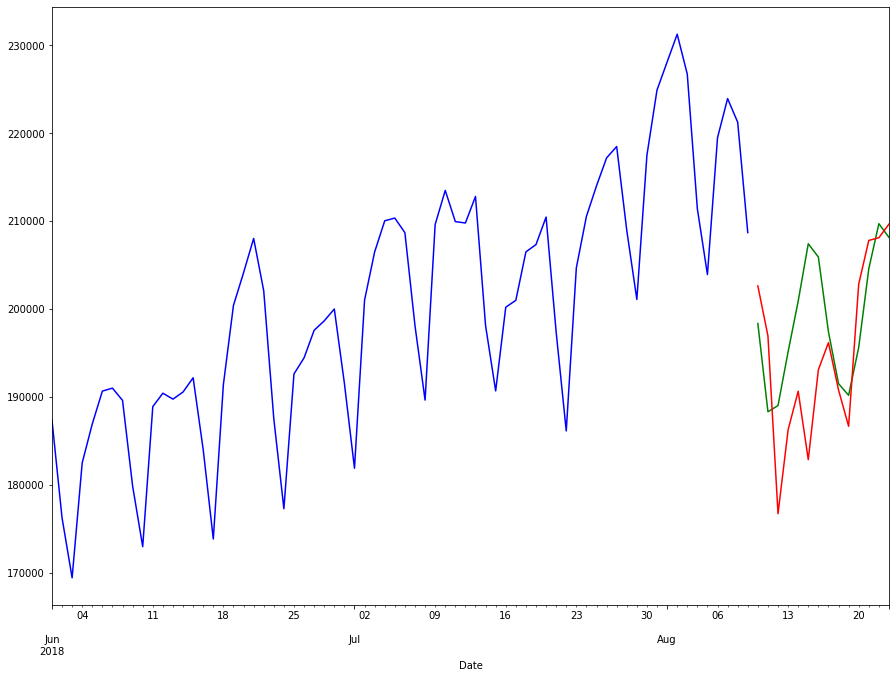

In [124]:
plt.figure(figsize=(15,11))
y_pred.plot(color = 'green')
X_train_endo.plot(color = 'blue')
y_true.plot(color = 'red')

MAPE_1 = mean_absolute_percentage_error(y_true, y_pred) # MAE en pourcentage 
y_baseline = np.ones(N_test)*X_train_endo[-1]
MAPE_baseline = mean_absolute_percentage_error(y_true, y_baseline) # MAE en pourcentage
print(f'MAPE_MODEL = {MAPE_1}, MAPE_baseline = {MAPE_baseline}')

In [75]:
#data[pd.date_range(start='20/12/2013', end='20/03/2014')]
#result = seasonal_decompose(X_train_endo, model='add')
#rcParams['figure.figsize'] = 15,8
#result.plot()

# check with ADF Test for stationarity
#print('p-value zero-diff: ', adfuller(X_train_endo)[1])
#print('p-value first-diff: ', adfuller(X_train_endo.diff().dropna())[1])
#print('p-value second-diff: ', adfuller(X_train_endo.diff().diff().dropna())[1])

In [76]:
# Build Model
#ARIMA(1,1,1)(1,0,1)[7]


#best model model = SARIMAX(X_train_endo, X_train_exo,order=(2, 1, 0), seasonal_order=(3, 0, 0, 7))

In [77]:
data

,Unnamed: 0,Code INSEE région,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),...,cos7_1,day_of_year,season,sin365_1,cos365_1,sin365_2,cos365_2,sin365_3,cos365_3,Date
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,4464.0,252371.0,15175.0,0.0,372.0,405.0,61254.0,-4.0,1808.0,...,0.623490,1,1,0.017202,0.999852,0.034398,0.999408,0.068755,0.997634,2013-01-01
2013-01-02,1.0,4464.0,280064.0,18369.0,0.0,1404.0,2655.0,70681.0,-12.0,1717.0,...,-0.222521,2,1,0.034398,0.999408,0.068755,0.997634,0.137185,0.990545,2013-01-02
2013-01-03,2.0,4464.0,285526.0,24755.0,0.0,626.0,2984.0,72282.0,0.0,2357.0,...,-0.900969,3,1,0.051584,0.998669,0.103031,0.994678,0.204966,0.978769,2013-01-03
2013-01-04,3.0,4464.0,286799.0,17085.0,0.0,1028.0,2570.0,68995.0,0.0,2988.0,...,-0.900969,4,1,0.068755,0.997634,0.137185,0.990545,0.271777,0.962360,2013-01-04
2013-01-05,4.0,4464.0,267848.0,15479.0,0.0,1557.0,2898.0,62143.0,0.0,3051.0,...,-0.222521,5,1,0.085906,0.996303,0.171177,0.985240,0.337301,0.941397,2013-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-11,3412.0,4464.0,218296.0,34225.0,0.0,1909.0,10139.0,40944.0,-306.0,3115.0,...,-0.222521,131,2,0.775859,-0.630907,-0.978989,-0.203914,0.399258,-0.916838,2022-05-11
2022-05-12,3413.0,4464.0,209770.0,47313.0,0.0,1695.0,15998.0,40585.0,-306.0,3177.0,...,-0.900969,132,2,0.764891,-0.644159,-0.985424,-0.170118,0.335276,-0.942120,2022-05-12
2022-05-13,3414.0,4464.0,201061.0,74913.0,0.0,1215.0,18002.0,41576.0,0.0,3561.0,...,-0.900969,133,2,0.753698,-0.657221,-0.990692,-0.136120,0.269707,-0.962943,2022-05-13


In [78]:
DICT = {'winter' : ['-12-21','-03-20',1], 'spring' : ['-03-21','-06-20',0] ,'summer' : ['-06-21','-09-22',0] ,'autumn' : ['-09-23','-12-20',0] }
year = [2013,2014,2015,2016,2017,2018,2019,2020,2021]
season = 'spring'

#spring sans [2,0,2], [2,0,1]
#autumn sans [2,0,1], [2,0,0]
#summer sans [2,0,1],[2,0,2]
#models = [[1,1,1],[0,1,1],[1,1,0],[1,0,1],[0,0,1],[1,0,0],[0,1,0],[2,0,0],[0,0,2],[1,0,2],[2,0,1],[2,0,2],[2,2,2]]
models = [[1,1,1],[0,1,1],[1,1,0],[1,0,1],[0,0,1],[1,0,0],[0,1,0],[2,0,0],[0,0,2],[1,0,2],[2,2,2]]

liste_result = np.zeros(len(models))#[0,0,0]
mean_baseline = 0

for yr in year:
    data_season = data[data['Date']>=pd.to_datetime(f'{yr}{DICT[season][0]}')]
    data_season = data_season[data_season['Date']<pd.to_datetime(f'{yr+DICT[season][2]}{DICT[season][1]}')]

    N = len(data_season)
    N_test = 14
    N_train = N-N_test
    X_train_endo = data_season['Consommation (MW)'][0:N-N_test]
    X_train_exo = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][0:N-N_test])
    X_test_exo  = np.array(data_season[['T2M','RH2M','sin7_1', 'cos7_1']][N-N_test:N])
    y_true = data_season['Consommation (MW)'][N-N_test:N]
    y_baseline = np.ones(N_test)*X_train_endo[-1]
    mean_baseline = mean_baseline + mean_absolute_percentage_error(y_true, y_baseline)/len(year)
    
    for i in range(0,len(models)):#models:
        print(f'Model {models[i][0],models[i][1],models[i][2]}')
        model = SARIMAX(X_train_endo, X_train_exo,order=(models[i][0], models[i][1], models[i][2]), seasonal_order=(0, 0, 0, 0))  
        model = model.fit(maxiter=200,disp=0)
        
        y_pred = model.predict(start = N_train,end=N_train + N_test-1,exog = X_test_exo,return_conf_int=True)
        MAPE_1 = mean_absolute_percentage_error(y_true, y_pred) # MAE en pourcentage 
        
        #print(f'test year {yr}, model {models[0],models[1],models[2]}, MAPE = {MAPE_1}')
        
        liste_result[i] = liste_result[i] + MAPE_1/len(year)
    
print(f'')  
print('CONCLUSION')  
print(f'baseline= {mean_baseline}')  
for i in range(0,len(models)):
    print(f'MAE_{i}={liste_result[i]} avec le model {models[i][0],models[i][1],models[i][2]}')

Model (1, 1, 1)
Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2, 0, 0)
Model (0, 0, 2)
Model (1, 0, 2)
Model (2, 2, 2)
Model (1, 1, 1)
Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2, 0, 0)
Model (0, 0, 2)
Model (1, 0, 2)
Model (2, 2, 2)
Model (1, 1, 1)
Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2, 0, 0)
Model (0, 0, 2)
Model (1, 0, 2)
Model (2, 2, 2)
Model (1, 1, 1)
Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2, 0, 0)
Model (0, 0, 2)
Model (1, 0, 2)
Model (2, 2, 2)
Model (1, 1, 1)
Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2, 0, 0)
Model (0, 0, 2)
Model (1, 0, 2)
Model (2, 2, 2)
Model (1, 1, 1)
Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2

/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Model (2, 2, 2)
Model (1, 1, 1)
Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2, 0, 0)
Model (0, 0, 2)
Model (1, 0, 2)
Model (2, 2, 2)
Model (1, 1, 1)


/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model (0, 1, 1)
Model (1, 1, 0)
Model (1, 0, 1)
Model (0, 0, 1)
Model (1, 0, 0)
Model (0, 1, 0)
Model (2, 0, 0)
Model (0, 0, 2)
Model (1, 0, 2)
Model (2, 2, 2)


/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



CONCLUSION
baseline= 0.05537712422961521
MAE_0=0.06568570720549133 avec le model (1, 1, 1)
MAE_1=0.06589863318643695 avec le model (0, 1, 1)
MAE_2=0.06591652305240345 avec le model (1, 1, 0)
MAE_3=0.6008878817055472 avec le model (1, 0, 1)
MAE_4=1.1251323143416294 avec le model (0, 0, 1)
MAE_5=0.6093421966443118 avec le model (1, 0, 0)
MAE_6=0.06600521400068236 avec le model (0, 1, 0)
MAE_7=0.6059515315320575 avec le model (2, 0, 0)
MAE_8=1.1082706345015003 avec le model (0, 0, 2)
MAE_9=0.44221214424940986 avec le model (1, 0, 2)
MAE_10=0.10913168142554609 avec le model (2, 2, 2)


In [79]:
#MAE_3=0.051168777009442216
#baseline= 0.05549745760483646

In [80]:
# autumn
#baseline= 0.05549745760483646
#MAE_1=0.04686756082956899 avec le model (0, 1, 1)
#MAE_2=0.04682811874120834 avec le model (1, 1, 0)
#winter
#baseline= 0.09845186997575217
#MAE_0=0.07305588609931297 avec le model (1, 1, 1)
#MAE_1=0.07262301390601439 avec le model (0, 1, 1)
#MAE_2=0.07251128276417924 avec le model (1, 1, 0)
#spring
#baseline= 0.05537712422961521
#MAE_0=0.06583321373456452 avec le model (1, 1, 1)
#MAE_1=0.06590010509439152 avec le model (0, 1, 1)
#MAE_2=0.06591910669210047 avec le model (1, 1, 0)
#summer
#baseline= 0.05537712422961521
#MAE_0=0.06583321373456452 avec le model (1, 1, 1)
#MAE_1=0.06590010509439152 avec le model (0, 1, 1)
#MAE_2=0.06591910669210047 avec le model (1, 1, 0)

In [96]:
#DICT_winter_2019 = DICT_model
DICT_winter_2020

{'[1, 1, 1]': {40: 0.06689765291951694,
  50: 0.06653315414220651,
  60: 0.06669378635597213,
  70: 0.06721130105543972,
  80: 0.06796676035713199,
  90: 0.06884713036426307,
  100: 0.06965611815410241,
  110: 0.07044625266409628,
  120: 0.07111022399928765,
  130: 0.07170905375018899,
  140: 0.07229915623330904},
 '[0, 1, 1]': {40: 0.07174746940790136,
  50: 0.07130925374624796,
  60: 0.07101120611473599,
  70: 0.07087314831288916,
  80: 0.07087933924934407,
  90: 0.07101388017544856,
  100: 0.07120738482701407,
  110: 0.0714409121738265,
  120: 0.07169632086212066,
  130: 0.0719721906589396,
  140: 0.07225632823664967},
 '[1, 1, 0]': {40: 0.07196948512383367,
  50: 0.07174489930717097,
  60: 0.07157617874811006,
  70: 0.07148806895175891,
  80: 0.07146760637164894,
  90: 0.07152849617006442,
  100: 0.07163006862565029,
  110: 0.07177280770542659,
  120: 0.07193358126786009,
  130: 0.07211249167234729,
  140: 0.07229785875897589},
 '[2, 2, 2]': {40: 0.07587009298697292,
  50: 0.079337

In [95]:
DICT_winter_2019

{'[1, 1, 1]': {40: 0.06777924129055292,
  50: 0.06755302487757407,
  60: 0.06744918899072043,
  70: 0.06732034671667701,
  80: 0.06730337744826037,
  90: 0.06740907652465666,
  100: 0.06773845399812356,
  110: 0.06811538449978644,
  120: 0.06844563325888649,
  130: 0.06878965186849258,
  140: 0.06911217583228993},
 '[0, 1, 1]': {40: 0.0689477948599253,
  50: 0.06882093223866949,
  60: 0.06870595606481625,
  70: 0.06859043156345146,
  80: 0.06851738542343776,
  90: 0.06848247676342395,
  100: 0.06854422330149448,
  110: 0.06864423913565523,
  120: 0.06877044428206147,
  130: 0.06892225073897051,
  140: 0.06907467583240172},
 '[1, 1, 0]': {40: 0.06897795949467614,
  50: 0.06889046343857412,
  60: 0.06880736629966097,
  70: 0.06874592771843076,
  80: 0.06867986214287866,
  90: 0.06864526665410131,
  100: 0.06866082465225463,
  110: 0.06869822932294836,
  120: 0.06876394521451645,
  130: 0.06885814364547167,
  140: 0.06895810532721139},
 '[2, 2, 2]': {40: 0.07215229044478737,
  50: 0.07551

In [99]:
DICT_winter_2018

{'[1, 1, 1]': {40: 0.06507985495554401,
  50: 0.06491504751289194,
  60: 0.06508091750524257,
  70: 0.06543079239694845,
  80: 0.06563807603267391,
  90: 0.06584012465625878,
  100: 0.06595350290091441,
  110: 0.0660737611982887,
  120: 0.06616727326019727,
  130: 0.06631817438291752,
  140: 0.06645717004570181},
 '[0, 1, 1]': {40: 0.06632455851599714,
  50: 0.06620358701708569,
  60: 0.06615230882157302,
  70: 0.06618088622795824,
  80: 0.06620596917783064,
  90: 0.066241976599558,
  100: 0.06626325378465985,
  110: 0.06630073946112922,
  120: 0.06633724968022718,
  130: 0.06640157949116085,
  140: 0.06647331966506799},
 '[1, 1, 0]': {40: 0.06642347170514733,
  50: 0.06638242489005326,
  60: 0.06636041552814852,
  70: 0.06637216427219855,
  80: 0.06640110238429875,
  90: 0.06643822216931994,
  100: 0.06646462795918034,
  110: 0.06650113474044186,
  120: 0.06654136125667356,
  130: 0.06659635588519021,
  140: 0.06665294504033273},
 '[2, 2, 2]': {40: 0.07096158882801187,
  50: 0.0753641

In [101]:
DICT_spring_2018

{'[1, 1, 1]': {40: 0.06990226725307924,
  50: 0.0684866461616455,
  60: 0.06825637172804265,
  70: 0.06858136551859641,
  80: 0.06876193542531826,
  90: 0.06884824062197199,
  100: 0.06896865286827106,
  110: 0.06897086266089356,
  120: 0.06896279605148618,
  130: 0.06899883311497194,
  140: 0.06904861433442852},
 '[0, 1, 1]': {40: 0.06910667567994702,
  50: 0.06894597679331348,
  60: 0.06884659969436255,
  70: 0.06887379532334796,
  80: 0.06890464221386852,
  90: 0.06892830408876656,
  100: 0.06897089875153734,
  110: 0.06897056288330577,
  120: 0.06896634460696176,
  130: 0.06898344419461501,
  140: 0.06900168771345395},
 '[1, 1, 0]': {40: 0.06904343392146389,
  50: 0.06894909253946285,
  60: 0.06886849479753068,
  70: 0.06885543221686487,
  80: 0.06886596210461256,
  90: 0.068871792081389,
  100: 0.06888317259832438,
  110: 0.06887980242034422,
  120: 0.06887061836802688,
  130: 0.06886515906616221,
  140: 0.06886764477815764},
 '[2, 2, 2]': {40: 0.07328789821015873,
  50: 0.0775356

In [103]:

DICT_spring_2019

{'[1, 1, 1]': {40: 0.04819755154890056,
  50: 0.04868839004446056,
  60: 0.04864138014624869,
  70: 0.04875363624922187,
  80: 0.04887878326957573,
  90: 0.048886946638008896,
  100: 0.04883495750114127,
  110: 0.04872711401973373,
  120: 0.048631669638612,
  130: 0.04855153109666237,
  140: 0.04847174983593816},
 '[0, 1, 1]': {40: 0.04835105340051897,
  50: 0.048397437084322655,
  60: 0.04838158264605963,
  70: 0.04847241363635714,
  80: 0.048545550155242666,
  90: 0.04856535124412761,
  100: 0.04856870313036195,
  110: 0.04854831940613808,
  120: 0.04851992374987074,
  130: 0.04848464783031737,
  140: 0.0484520760773035},
 '[1, 1, 0]': {40: 0.04847300028979047,
  50: 0.04853538554759147,
  60: 0.048588190900639774,
  70: 0.048686879240989626,
  80: 0.048766936557043956,
  90: 0.04880539824310394,
  100: 0.04886911201459784,
  110: 0.04889951306959616,
  120: 0.04891725228667053,
  130: 0.048907472628085195,
  140: 0.048901952955101184},
 '[2, 2, 2]': {40: 0.05359863576954007,
  50: 0

In [105]:
DICT_spring_2020

{'[1, 1, 1]': {40: 0.05624681707369112,
  50: 0.056374763361419736,
  60: 0.0561524970174148,
  70: 0.0562613106882881,
  80: 0.056432484320670905,
  90: 0.05649949376355654,
  100: 0.05655202987654581,
  110: 0.05656011433836531,
  120: 0.0566274458140089,
  130: 0.05668451866810866,
  140: 0.05679244078635178},
 '[0, 1, 1]': {40: 0.056788846820565037,
  50: 0.05677226739535551,
  60: 0.0567057122468581,
  70: 0.056728220972221195,
  80: 0.05672971290964141,
  90: 0.05673986248894646,
  100: 0.05676130252663423,
  110: 0.05675910080056426,
  120: 0.05676415015500294,
  130: 0.056779865105745994,
  140: 0.05682672355330286},
 '[1, 1, 0]': {40: 0.056816380501452525,
  50: 0.056801382368044426,
  60: 0.056757783792718286,
  70: 0.05676541819527928,
  80: 0.0567530125821056,
  90: 0.05674589441977087,
  100: 0.056747782939738645,
  110: 0.05673923893966668,
  120: 0.05672969666928461,
  130: 0.0567369524561931,
  140: 0.056766183857092485},
 '[2, 2, 2]': {40: 0.06078516239844843,
  50: 0.

In [107]:
DICT_P3_2019

{'[1, 1, 1]': {40: 0.04659415281954405,
  50: 0.04656865432870789,
  60: 0.04660765453656824,
  70: 0.04707419563198987,
  80: 0.04768824586403387,
  90: 0.04846768398031921,
  100: 0.04922551405830193,
  110: 0.05006236900339083,
  120: 0.05081382990310825,
  130: 0.051598067677709435,
  140: 0.052330028557065644},
 '[0, 1, 1]': {40: 0.05175988626452203,
  50: 0.05131437807102269,
  60: 0.0509641273191096,
  70: 0.050795255485134944,
  80: 0.05073932361642231,
  90: 0.050820486554260844,
  100: 0.050989632225072426,
  110: 0.05123822808225755,
  120: 0.05152711453601949,
  130: 0.05186180770069185,
  140: 0.052214993171887526},
 '[1, 1, 0]': {40: 0.05193032535646181,
  50: 0.05168926805417319,
  60: 0.05150903753433831,
  70: 0.051417502396695576,
  80: 0.05138535970545382,
  90: 0.05142697417047917,
  100: 0.05153523666201694,
  110: 0.051685245518473706,
  120: 0.05188290050902549,
  130: 0.05211235207923655,
  140: 0.05235868846361397},
 '[2, 2, 2]': {40: 0.05566952363781761,
  50:

In [110]:
DICT_P3_2018

{'[1, 1, 1]': {40: 0.04659415281954405,
  50: 0.04656865432870789,
  60: 0.04660765453656824,
  70: 0.04707419563198987,
  80: 0.04768824586403387,
  90: 0.04846768398031921,
  100: 0.04922551405830193,
  110: 0.05006236900339083,
  120: 0.05081382990310825,
  130: 0.051598067677709435,
  140: 0.052330028557065644},
 '[0, 1, 1]': {40: 0.05175988626452203,
  50: 0.05131437807102269,
  60: 0.0509641273191096,
  70: 0.050795255485134944,
  80: 0.05073932361642231,
  90: 0.050820486554260844,
  100: 0.050989632225072426,
  110: 0.05123822808225755,
  120: 0.05152711453601949,
  130: 0.05186180770069185,
  140: 0.052214993171887526},
 '[1, 1, 0]': {40: 0.05193032535646181,
  50: 0.05168926805417319,
  60: 0.05150903753433831,
  70: 0.051417502396695576,
  80: 0.05138535970545382,
  90: 0.05142697417047917,
  100: 0.05153523666201694,
  110: 0.051685245518473706,
  120: 0.05188290050902549,
  130: 0.05211235207923655,
  140: 0.05235868846361397},
 '[2, 2, 2]': {40: 0.05566952363781761,
  50:

In [112]:
DICT_P3_2020

{'[1, 1, 1]': {40: 0.037763323580975824,
  50: 0.03786864656401455,
  60: 0.03766470318341765,
  70: 0.037597855795683664,
  80: 0.037954722758261686,
  90: 0.03848293031014068,
  100: 0.03900225038680873,
  110: 0.039557957815571795,
  120: 0.04017780807481254,
  130: 0.04079442615873382,
  140: 0.04143092718912696},
 '[0, 1, 1]': {40: 0.041141662872834536,
  50: 0.0408519657199509,
  60: 0.04060884453588614,
  70: 0.040414156653021685,
  80: 0.040330965233517306,
  90: 0.0403907559454501,
  100: 0.040486224309392076,
  110: 0.04064843615869877,
  120: 0.04087461931621444,
  130: 0.04113984293848873,
  140: 0.041435403620745694},
 '[1, 1, 0]': {40: 0.041378300979730324,
  50: 0.041320165765339395,
  60: 0.0412535283843334,
  70: 0.041203914523102785,
  80: 0.04121162686945403,
  90: 0.041296445818202646,
  100: 0.041394565807054313,
  110: 0.041532362703791986,
  120: 0.041687555272325524,
  130: 0.04187350831986382,
  140: 0.04207959580026803},
 '[2, 2, 2]': {40: 0.04564762596128532,